In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


## Veri setini yükleme

In [2]:
df=pd.read_csv('international-airline-passengers.csv')

## Veri setine göz atma

In [3]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
df.columns=['Month','Passenger']

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passenger,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [15]:
result= df.copy()

## Veri setini görselleştirme

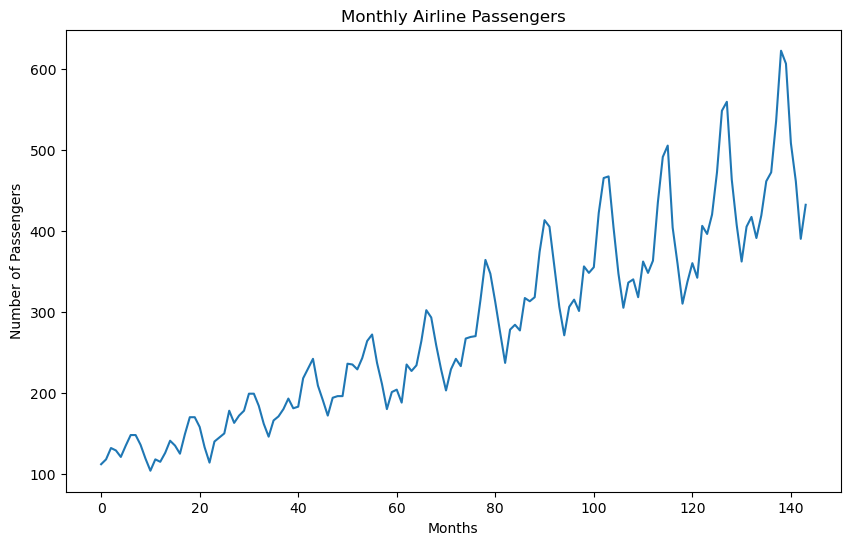

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(df['Passengers'])
plt.title('Monthly Airline Passengers')
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.show()

In [74]:
# Veri setini numpy dizisine dönüştürme
data = df['Passengers'].values.astype(float)

In [75]:
# Veri setini normalize etme
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [76]:
def split_data(dataframe, test_size):
    position= int(round(len(dataframe)*(1-test_size)))
    train= dataframe[:position]
    test= dataframe[position:]
    return train,test,position

In [77]:
train, test, position= split_data(data,0.33)

In [78]:
print(train.shape, test.shape)

(96,) (48,)


In [82]:
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

look_back = 12  # Önceki 12 ayı kullanarak tahmin yapacağız
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [83]:
# Veri şeklini yeniden düzenleme (örnek, özellikler, zaman adımları)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [84]:
# RNN modeli oluşturma
model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))


In [85]:
# Modeli derleme
model.compile(loss='mean_squared_error', optimizer='adam')

In [88]:
# Modelin eğitimi
history = model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)


Epoch 1/100
84/84 [==============================] - 1s 5ms/step - loss: 6588.9556 - val_loss: 12849.1260
Epoch 2/100
84/84 [==============================] - 0s 2ms/step - loss: 5914.8213 - val_loss: 10351.3535
Epoch 3/100
84/84 [==============================] - 0s 2ms/step - loss: 5514.0303 - val_loss: 11076.1660
Epoch 4/100
84/84 [==============================] - 0s 2ms/step - loss: 3782.5625 - val_loss: 7274.0996
Epoch 5/100
84/84 [==============================] - 0s 2ms/step - loss: 3186.3691 - val_loss: 6580.5762
Epoch 6/100
84/84 [==============================] - 0s 2ms/step - loss: 3477.0745 - val_loss: 5592.8721
Epoch 7/100
84/84 [==============================] - 0s 2ms/step - loss: 2789.2031 - val_loss: 5003.6870
Epoch 8/100
84/84 [==============================] - 0s 2ms/step - loss: 2875.5317 - val_loss: 4836.3101
Epoch 9/100
84/84 [==============================] - 0s 2ms/step - loss: 2275.9507 - val_loss: 3875.6233
Epoch 10/100
84/84 [==============================] 

In [89]:
# Modelin değerlendirmesi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


2/2 [==============================] - 0s 2ms/step


In [90]:
# Tahmin edilen verileri geri dönüştürme
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [91]:
# Tahmin performansını hesaplama
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))

print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

Train RMSE: 13195.808402529496
Test RMSE: 30313.034289261355


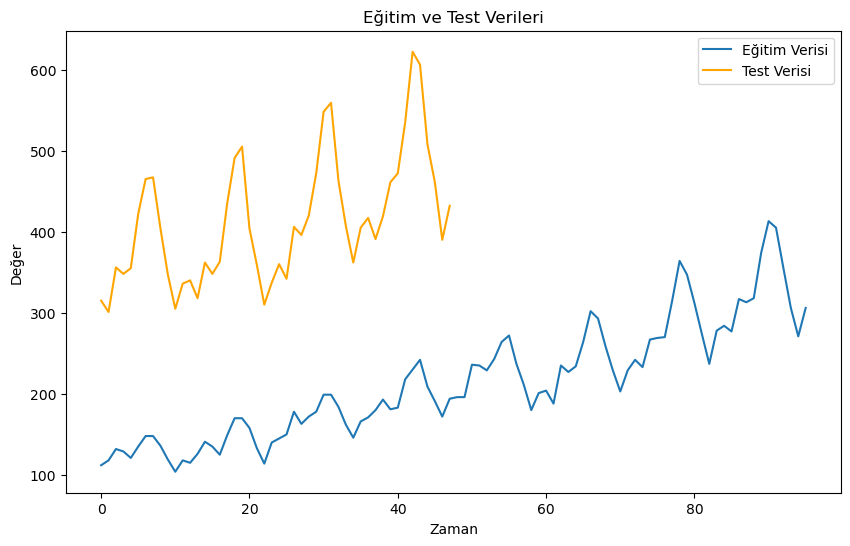

In [94]:
plt.figure(figsize=(10, 6))

# Eğitim verisinin görselleştirilmesi
plt.plot(train, label='Eğitim Verisi')

# Test verisinin görselleştirilmesi
plt.plot(test, label='Test Verisi', color='orange')

plt.title('Eğitim ve Test Verileri')
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.legend()
plt.show()
